In [4]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.metrics import structural_similarity as ssim
from keras.models import load_model

In [13]:
# Fairface
def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder(input_latent=256):
    input_img = tf.keras.Input(shape=(150, 150, 1))
    x = tf.keras.layers.Conv2D(16, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 32, 3, 2)
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 256, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 1024, 3, 2)
    x = residual_block(x, 2048, 3, 2)
    x = residual_block(x, input_latent, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer_norm)
    x_recon = residual_block_recon(reshape_layer, input_latent, 3, 1)
    x_recon = residual_block_recon(x_recon, 2048, 3, 2)
    x_recon = residual_block_recon(x_recon, 1024, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)
    
    x_recon = residual_block_recon(x_recon, 16, 3, 2)
    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(150, 150)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=x_recon)
    lr1 = 0.01
    lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=42237,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.summary()
    return model

In [1]:
def generator_to_array(generator):
    # Initialiser une liste pour stocker les échantillons
    num_samples = len(generator)
    samples = []
    # Itérer sur le générateur pour obtenir les échantillons
    for i in range(num_samples):
        batch = generator.next()
        for image in batch[0]:
            samples.append(image)  # Ajouter uniquement les données (ignorer les étiquettes)
    return np.array(samples)

def mean_cosinus_similarity(v1, v2):
    cosinus_similarity = 0
    nb_individus = v1.shape[0]
    for i in range(nb_individus):
        cosinus_similarity += np.dot(v1[i], v2[i]) / (np.linalg.norm(v1[i]) * np.linalg.norm(v2[i]))
    return cosinus_similarity/nb_individus

def calculate_mean_dispersion(latent_representations):
    centroid = np.mean(latent_representations, axis=0)
    distance_squared = np.sum((latent_representations - centroid)**2, axis = 1)
    return np.mean(distance_squared)

def comparaison_visages(asian, asian_predict, white, white_predict, ethnie):

    plt.figure(figsize=(15, 6))

    # Affichage des images du premier trainset
    plt.subplot(2, 5, (1, 5))
    plt.axis("off")
    plt.title('Caucasiens')
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(white[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(white_predict[i], cmap='gray')
        plt.axis('off')

    # Titre global
    plt.suptitle(f'Comparaison des images d entrées et de sorties caucasiennes d espace latent {ethnie}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 6))

    # Affichage des images du premier trainset
    plt.subplot(2, 5, (1, 5))
    plt.axis("off")
    plt.title('Asiatiques')
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(asian[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(asian_predict[i], cmap='gray')
        plt.axis('off')

    # Titre global
    plt.suptitle('Comparaison des images d entrées et de sorties asiatiques')
    plt.tight_layout()
    plt.show()

def pca(latent_asian, latent_white, ethnie):
    pca = PCA(n_components=2)
    latent_pca_white = pca.fit_transform(latent_white)
    latent_pca_asian = pca.fit_transform(latent_asian)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_pca_white[:, 0], latent_pca_white[:, 1], color='r', alpha=0.5, label='white_predict')
    scatter_b = plt.scatter(latent_pca_asian[:, 0], latent_pca_asian[:, 1], color='b', alpha=0.5, label='asian_predict')
    plt.legend(handles=[scatter, scatter_b])
    plt.title(f'Projection ACP de l espace latent {ethnie}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    return np.concatenate([latent_pca_white, latent_pca_asian], axis=0)


def cosinus_similarity(asian_flatten, asian_predict_flatten, white_flatten, white_predict_flatten):
    asian_cs = mean_cosinus_similarity(asian_flatten, asian_predict_flatten)
    white_cs = mean_cosinus_similarity(white_flatten, white_predict_flatten)
    print(f"Moyenne des similarités cosinus pour les individus caucasiens : {white_cs}")
    print(f"Moyenne des similarités cosinus pour les individus asiatiques : {asian_cs}")
    
def comparaison_dispersion(latent_asian, latent_white):
    asian_mean_dispersion = calculate_mean_dispersion(latent_asian)
    white_mean_dispersion = calculate_mean_dispersion(latent_white)
    print(f"Moyenne des dispersions des espaces latents pour les individus caucasiens : {white_mean_dispersion}")
    print(f"Moyenne des dispersions des espaces latents pour les individus asiatiques : {asian_mean_dispersion}")

def coef_bhattacharyya(P, Q):
    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    return np.sum(np.sqrt(P * Q))

def ssim_mean(ytrue, ypred, length):    
    res = 0
    for i in range(length):
        res+=ssim(ytrue[i], ypred[i], data_range=ypred.max()-ypred.min())
    
    return res/length

def msn_dnn(model, Bmax, Bmin)

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
trainset_white = train_datagen.flow_from_directory(
    '../../Datasets/UTK_cropped/Train',
    classes=['Caucasiens'],
    target_size=(150, 150), 
    batch_size=64, 
    class_mode='input',
    color_mode='grayscale')
testset_white = train_datagen.flow_from_directory(
    '../../Datasets/UTK_cropped/Test',
    classes=['Caucasiens'],
    target_size=(150, 150), 
    batch_size=64, 
    class_mode='input',
    color_mode='grayscale')
trainset_asian = train_datagen.flow_from_directory(
    '../../Datasets/UTK_cropped/Train',
    classes=['Asiatiques'],
    target_size=(150, 150),
    batch_size=64,
    class_mode='input',
    color_mode='grayscale')
testset_asian = train_datagen.flow_from_directory(
    '../../Datasets/UTK_cropped/Test',
    classes=['Asiatiques'],
    target_size=(150, 150),
    batch_size=64,
    class_mode='input',
    color_mode='grayscale')
dataset_mixed = train_datagen.flow_from_directory(
    '../../Datasets/UTK_cropped/Train',
    target_size=(150, 150), 
    batch_size=64, 
    class_mode='binary',
    color_mode='grayscale')
dataset_mixed = train_datagen.flow_from_directory(
    '../../Datasets/UTK_cropped/Test',
    target_size=(150, 150), 
    batch_size=64, 
    class_mode='binary',
    color_mode='grayscale')

Found 2500 images belonging to 1 classes.
Found 900 images belonging to 1 classes.
Found 2500 images belonging to 1 classes.
Found 900 images belonging to 1 classes.
Found 5000 images belonging to 2 classes.
Found 1800 images belonging to 2 classes.


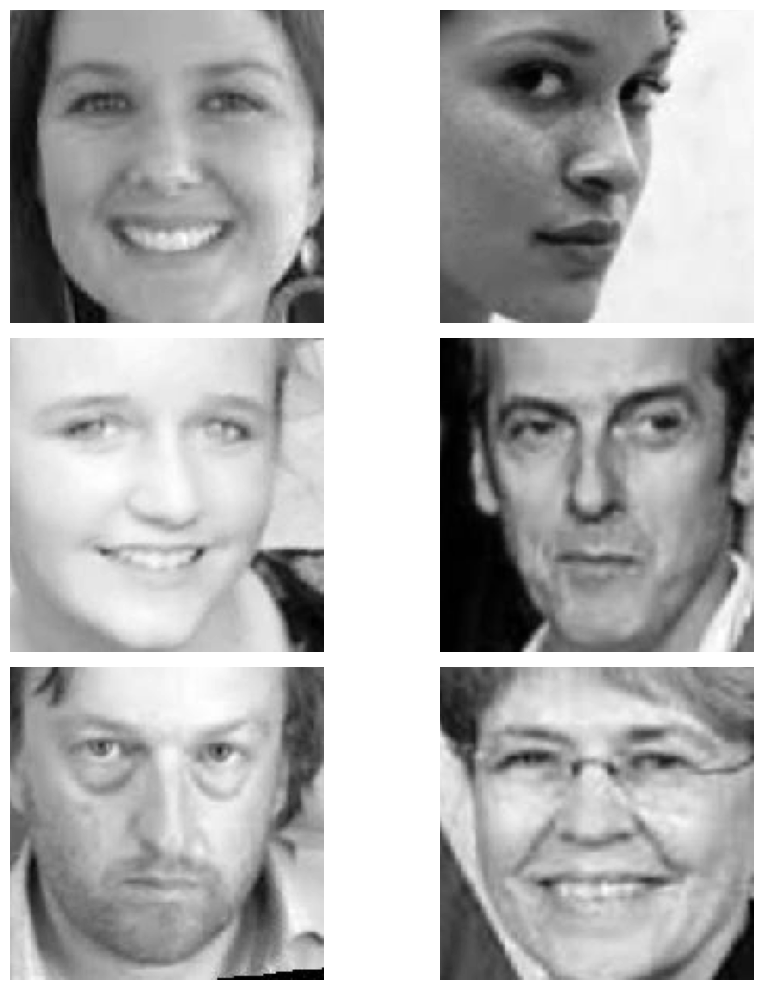

In [5]:
# Récupérer un lot d'images du générateur
batch = next(trainset_white)

# Extraire les images et les étiquettes du lot
images = batch[0]
labels = batch[1]

num_rows = 3
num_cols = 2

plt.figure(figsize=(10, 10))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[i].reshape((150,150)), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
model = create_resnet_autoencoder(input_latent=512)
chekpoint_path = 'Modeles/UTK/utk_autoencoder_white_512.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=chekpoint_path,
    save_weights_only=False,
    save_frequency='epoch',
    save_best_only=True
    )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 16)   144         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [5]:
#model = load_model('Modeles/UTK/utk_autoencoder_white_256.hdf5')

In [15]:
model.fit(x=trainset_white, epochs=1500, batch_size=64, validation_data=testset_white, callbacks=[checkpoint_callback])

Epoch 1/1500
40/40 [==============================] - 34s 641ms/step - loss: 0.0748 - mae: 0.2146 - val_loss: 0.0520 - val_mae: 0.1908
Epoch 2/1500
40/40 [==============================] - 21s 529ms/step - loss: 0.0544 - mae: 0.1874 - val_loss: 0.0532 - val_mae: 0.1934
Epoch 3/1500
40/40 [==============================] - 21s 530ms/step - loss: 0.0498 - mae: 0.1811 - val_loss: 0.0532 - val_mae: 0.1935
Epoch 4/1500
40/40 [==============================] - 24s 613ms/step - loss: 0.0474 - mae: 0.1768 - val_loss: 0.0537 - val_mae: 0.1945
Epoch 5/1500
40/40 [==============================] - 43s 1s/step - loss: 0.0462 - mae: 0.1740 - val_loss: 0.0545 - val_mae: 0.1963
Epoch 6/1500
40/40 [==============================] - 21s 529ms/step - loss: 0.0443 - mae: 0.1700 - val_loss: 0.0556 - val_mae: 0.1984
Epoch 7/1500
40/40 [==============================] - 21s 529ms/step - loss: 0.0432 - mae: 0.1674 - val_loss: 0.0572 - val_mae: 0.2016
Epoch 8/1500
40/40 [==============================] - 21s 

In [16]:
get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('latent_space_layer_norm').output)

In [17]:
latent_asian = get_latent.predict(trainset_asian)
latent_white = get_latent.predict(trainset_white)

asian_predict = model.predict(trainset_asian).reshape(2500,150,150)
white_predict = model.predict(trainset_white).reshape(2500,150,150)
asian = generator_to_array(trainset_asian).reshape(2500,150,150)
white = generator_to_array(trainset_white).reshape(2500,150,150)

asian_predict_flatten = asian_predict.reshape(2500, -1)
white_predict_flatten = white_predict.reshape(2500, -1)
asian_flatten = asian.reshape(2500, -1)
white_flatten = white.reshape(2500, -1)

40/40 [==============================] - 6s 147ms/step


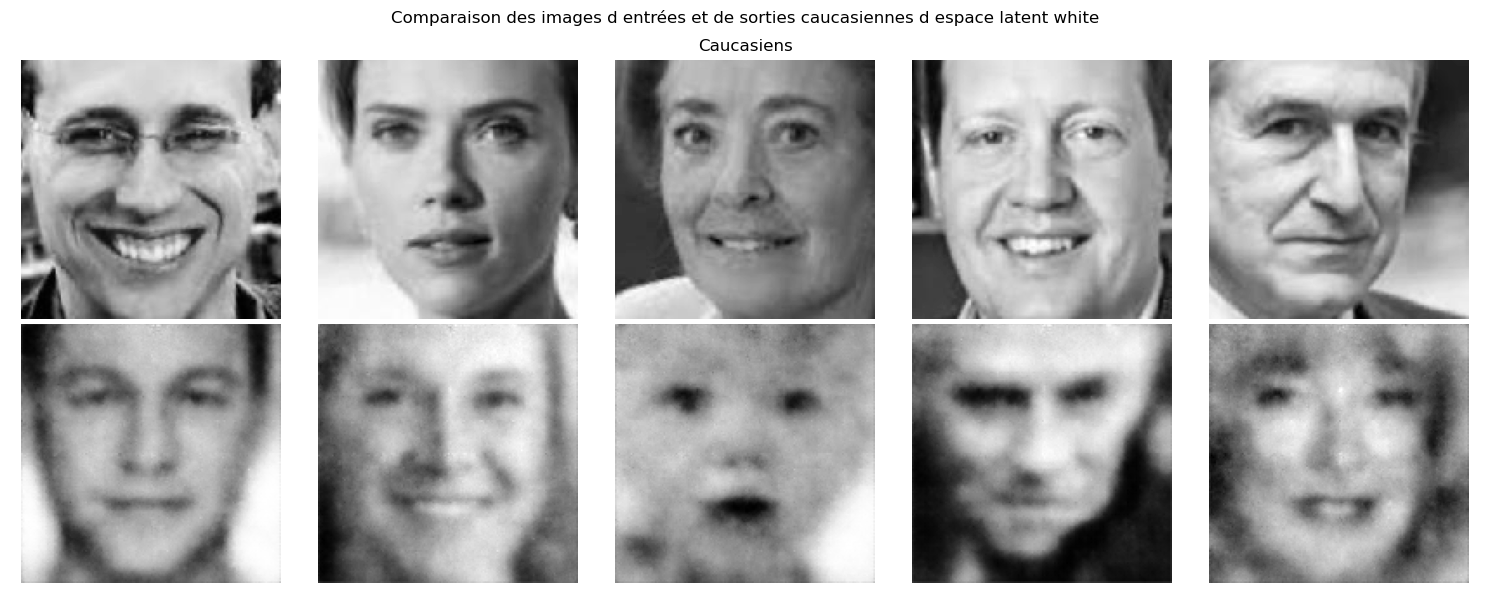

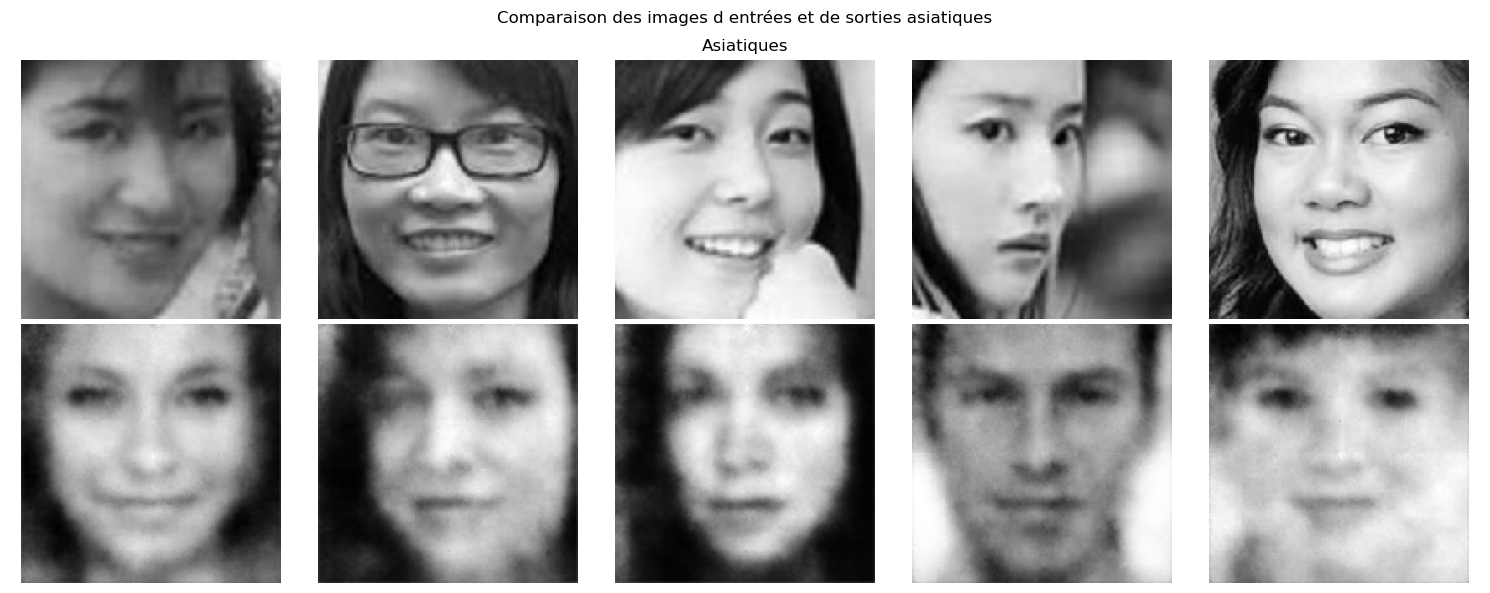

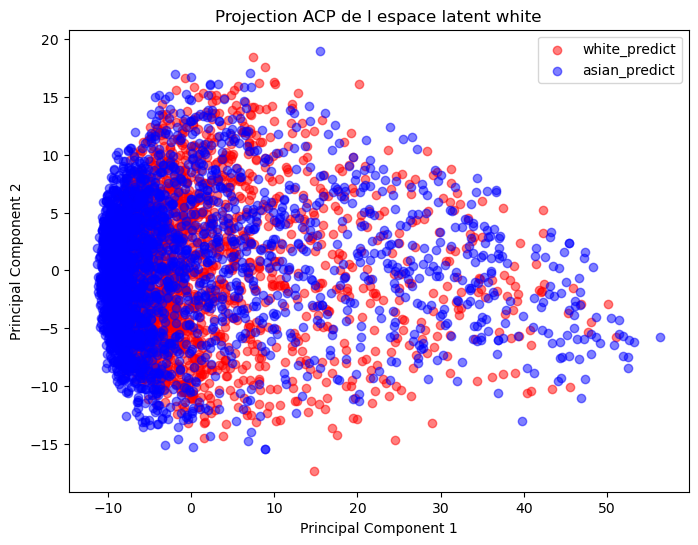

Moyenne des similarités cosinus pour les individus caucasiens : 0.8974037096738815
Moyenne des similarités cosinus pour les individus asiatiques : 0.8876452081441879
La similarité structurelle pour les caucasiens est de : 0.33195395279466305
La similarité structurelle pour les asiatiques est de : 0.33928031861946234
Moyenne des dispersions des espaces latents pour les individus caucasiens : 501.62384033203125
Moyenne des dispersions des espaces latents pour les individus asiatiques : 531.774169921875


In [18]:
##----------------------------------------------Analyse Qualitative
comparaison_visages(asian, asian_predict, white, white_predict, "white")
latent_pca = pca(latent_asian, latent_white, "white")
cosinus_similarity(asian_flatten, asian_predict_flatten, white_flatten, white_predict_flatten)
print(f"La similarité structurelle pour les caucasiens est de : {ssim_mean(white, white_predict, 2500)}")
print(f"La similarité structurelle pour les asiatiques est de : {ssim_mean(asian, asian_predict, 2500)}")
comparaison_dispersion(latent_asian, latent_white)

In [19]:
ssim(white, white_predict, data_range=white.max() - white.min())

0.01676061115538695

In [20]:
ssim(asian, asian_predict, data_range=asian.max() - asian.min())

0.02878858693918516

In [21]:
white

array([[[0.07450981, 0.227451  , 0.27450982, ..., 0.46274513,
         0.5254902 , 0.54509807],
        [0.10588236, 0.14509805, 0.24313727, ..., 0.43921572,
         0.59607846, 0.627451  ],
        [0.09411766, 0.13725491, 0.25882354, ..., 0.4039216 ,
         0.56078434, 0.5764706 ],
        ...,
        [0.01176471, 0.01960784, 0.03137255, ..., 0.2392157 ,
         0.20000002, 0.20784315],
        [0.01568628, 0.02352941, 0.04705883, ..., 0.35686275,
         0.16862746, 0.15294118],
        [0.04313726, 0.0509804 , 0.07450981, ..., 0.39607847,
         0.21960786, 0.20784315]],

       [[0.8431373 , 0.80392164, 0.7803922 , ..., 0.20392159,
         0.19607845, 0.19215688],
        [0.8470589 , 0.81568635, 0.78823537, ..., 0.19215688,
         0.18431373, 0.18039216],
        [0.854902  , 0.8235295 , 0.7960785 , ..., 0.18431373,
         0.1764706 , 0.17254902],
        ...,
        [0.9803922 , 0.9803922 , 0.9803922 , ..., 0.9725491 ,
         0.94117653, 0.9607844 ],
        [0.9

In [22]:
white.shape

(2500, 150, 150)

In [36]:
def create_triplets(image_array, labels):
    triplets = []
    
    for i in range(len(image_array)):
        anchor = image_array[i]
        label = labels[i]
        
        # Sélectionner une image positive (même label mais image différente)
        positive_indices = np.where(labels == label)[0]
        positive_indices = positive_indices[positive_indices != i]  # Enlever l'ancre
        positive = image_array[np.random.choice(positive_indices)]
        
        # Sélectionner une image négative (label différent)
        negative_indices = np.where(labels != label)[0]
        negative = image_array[np.random.choice(negative_indices)]
        
        triplets.append((anchor, positive, negative))
        
    return np.array(triplets)

TypeError: Invalid shape (150,) for image data

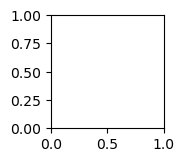

In [26]:
def plot_triplets(triplets):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        # Plot anchor image
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(triplets[i][0], cmap='gray')
        plt.title('Anchor Image')
        plt.axis('off')

        # Plot positive image
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(triplets[i][1], cmap='gray')
        plt.title('Positive Image')
        plt.axis('off')

        # Plot negative image
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(triplets[i][2], cmap='gray')
        plt.title('Negative Image')
        plt.axis('off')

    plt.show()

# Supposons que vous ayez déjà créé vos triplets
# triplets = create_triplets(image_array, labels_array)

# Maintenant, nous appelons la fonction plot_triplets pour afficher les résultats
plot_triplets(white[:3])

In [37]:
bizarre = np.concatenate([white[:3], asian[:3]], axis=0)

In [38]:
trip = create_triplets(bizarre, ["white", "white","white", "asian", "asian", "asian"])

C:\Users\Guilem\AppData\Local\Temp\ipykernel_16732\4098326679.py:9: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  positive_indices = np.where(labels == label)[0]


ValueError: 'a' cannot be empty unless no samples are taken

In [39]:
bizarre.shape

(6, 150, 150)